In [1]:
import pandas as pd
file_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
iris = pd.read_csv(file_name, names=["sepal_length","sepal_width","petal_length", "petal_width","species"])

In [2]:
import pyspark
from pyspark.sql import Row

myConf = pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
.builder\
.master('local')\
.appName('myApp')\
.config(conf=myConf)\
.getOrCreate()

21/12/18 18:51:42 WARN Utils: Your hostname, Kritiasui-MacBookAir.local resolves to a loopback address: 127.0.0.1; using 172.30.1.23 instead (on interface en0)
21/12/18 18:51:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/12/18 18:51:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/18 18:51:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
21/12/18 18:51:45 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


# 1. Dataframe 생성

In [3]:
myDf = spark.createDataFrame(iris)
myDf.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



# 2. 회귀선 그래프

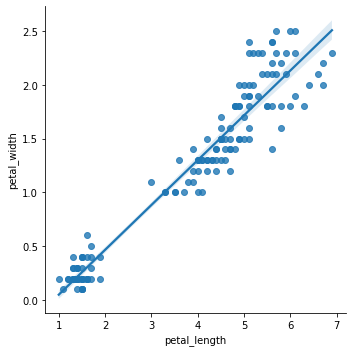

In [4]:
import seaborn as sns

sns.lmplot(x="petal_length", y="petal_width", data=iris)

# 3. Spark를 사용하여 회귀분석하고 계수 출력

In [7]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

# 훈련데이터 9:1로 분리
(testDf, trainDf) = myDf.randomSplit([0.2, 0.8])
# 교재대로 진행 후 계수 출력
va = VectorAssembler(inputCols = ['petal_length'],
                                   outputCol = 'features')
lr = LinearRegression(featuresCol = 'features', labelCol='petal_width')
pipeline = Pipeline(stages=[va, lr])

In [8]:
model = pipeline.fit(myDf)
modelTrainDf = model.transform(myDf)
print("Coefficients: {}".format(model.stages[-1].coefficients))

21/12/18 18:53:09 WARN Instrumentation: [20aa26c9] regParam is zero, which might cause numerical instability and overfitting.
21/12/18 18:53:10 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
21/12/18 18:53:10 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


Coefficients: [0.41641913228540195]


# 4. 실제와 예측 출력

In [9]:
# 실제와 예측 컬럼 show
modelTestDf=model.transform(testDf)
modelTestDf.select('petal_width','prediction').show(10)

+-----------+-------------------+
|petal_width|         prediction|
+-----------+-------------------+
|        0.2|0.17483082675429112|
|        0.2|0.17483082675429112|
|        0.2|0.04990508706867053|
|        0.1|0.21647273998283129|
|        1.7| 1.5073720500675774|
|        0.1|0.25811465321137145|
|        0.6| 0.2997565664399117|
|        1.1| 0.8827433516394743|
|        0.2|0.21647273998283129|
|        0.2| 0.2997565664399117|
+-----------+-------------------+
only showing top 10 rows



# 5. 정확성 출력

In [10]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol="petal_width", predictionCol="prediction", metricName="rmse")
rmse=evaluator.evaluate(modelTestDf)
f"Root Mean Squared Error (RMSE) on test data: {rmse:.3f}"

'Root Mean Squared Error (RMSE) on test data: 0.236'